# Here we try a VAE and lie detection

- first we train a VAE
- then we freeze the VAE and train the lie detector

Experiment: big VAE, w conv, wo tied weight



links:
- [loading](https://github.com/deep-diver/LLM-As-Chatbot/blob/main/models/alpaca.py)
- [dict](https://github.com/deep-diver/LLM-As-Chatbot/blob/c79e855a492a968b54bac223e66dc9db448d6eba/model_cards.json#L143)
- [prompt_format](https://github.com/deep-diver/PingPong/blob/main/src/pingpong/alpaca.py)

In [1]:
# import your package
%load_ext autoreload
%autoreload 2


In [2]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
plt.style.use('ggplot')

from typing import Optional, List, Dict, Union

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import Tensor
from torch import optim
from torch.utils.data import random_split, DataLoader, TensorDataset
from src.helpers.ds import shuffle_dataset_by
from pathlib import Path

import transformers

import lightning.pytorch as pl
# from dataclasses import dataclass

# from sklearn.linear_model import LogisticRegression
# from sklearn.metrics import f1_score, roc_auc_score, accuracy_score
# from sklearn.preprocessing import RobustScaler

from tqdm.auto import tqdm
import os

from loguru import logger
logger.add(os.sys.stderr, format="{time} {level} {message}", level="INFO")



transformers.__version__


/media/wassname/SGIronWolf/projects5/elk/discovering_latent_knowledge/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


'4.34.1'

In [3]:
from src.helpers.lightning import read_metrics_csv


# Datasets



In [4]:
[str(s) for s in sorted(Path('../.ds/').glob('*'))]


['../.ds/TheBloke_Mistral-7B-Instruct-v0.1-GPTQ_amazon_polarity_test_220',
 '../.ds/TheBloke_Mistral-7B-Instruct-v0.1-GPTQ_amazon_polarity_train_3690',
 '../.ds/TheBloke_Mistral-7B-Instruct-v0.1-GPTQ_glue_qnli_test_220',
 '../.ds/TheBloke_Mistral-7B-Instruct-v0.1-GPTQ_glue_qnli_train_1690',
 '../.ds/TheBloke_Mistral-7B-Instruct-v0.1-GPTQ_imdb_test_220',
 '../.ds/TheBloke_Mistral-7B-Instruct-v0.1-GPTQ_imdb_train_1690',
 '../.ds/TheBloke_Mistral-7B-Instruct-v0.1-GPTQ_super_glue_boolq_test_220',
 '../.ds/TheBloke_Mistral-7B-Instruct-v0.1-GPTQ_super_glue_boolq_train_1690']

In [5]:
from datasets import load_from_disk, concatenate_datasets
from src.datasets.load import ds2df, load_ds, get_ds_name

# feats = ['hidden_states', 'head_activation_and_grad', 'mlp_activation_and_grad', 'residual_stream', 'w_grads_attn', 'w_grads_mlp', 'hidden_states2', 'residual_stream2', ]

fs = [
    # '../.ds/TheBloke_Mistral-7B-Instruct-v0.1-GPTQ_amazon_polarity_test_220',
#  '../.ds/TheBloke_Mistral-7B-Instruct-v0.1-GPTQ_amazon_polarity_test_80',
#  '../.ds/TheBloke_Mistral-7B-Instruct-v0.1-GPTQ_amazon_polarity_train_1690',
 '../.ds/TheBloke_Mistral-7B-Instruct-v0.1-GPTQ_amazon_polarity_train_3690',
#  '../.ds/TheBloke_Mistral-7B-Instruct-v0.1-GPTQ_amazon_polarity_train_50',
#  '../.ds/TheBloke_Mistral-7B-Instruct-v0.1-GPTQ_glue_qnli_test_220',
 '../.ds/TheBloke_Mistral-7B-Instruct-v0.1-GPTQ_glue_qnli_train_1690',
#  '../.ds/TheBloke_Mistral-7B-Instruct-v0.1-GPTQ_imdb_test_219',
 '../.ds/TheBloke_Mistral-7B-Instruct-v0.1-GPTQ_imdb_train_1690',
#  '../.ds/TheBloke_Mistral-7B-Instruct-v0.1-GPTQ_super_glue_boolq_test_220',
#  '../.ds/TheBloke_Mistral-7B-Instruct-v0.1-GPTQ_super_glue_boolq_train_1690'
 ]

dss = [load_ds(f) for f in fs]


## QC datasets

In [6]:
from src.datasets.load import ds2df, load_ds, get_ds_name, filter_ds_to_known


In [7]:
for ds in dss:
    ds = ds.with_format('numpy')
    ds_name = get_ds_name(ds)
    print('ds', ds_name)
    df = ds2df(ds)
    
    # check llm accuracy
    d = df.query('instructed_to_lie==False')
    acc = (d.label_instructed==d.llm_ans).mean()
    assert np.isfinite(acc)
    print(f"\tacc    =\t{acc:2.2%} [N={len(d)}] - when the model is not lying... we get this task acc")
    
    # check LLM lie freq
    d = df.query('instructed_to_lie==True')
    acc = (d.label_instructed==d.llm_ans).mean()
    assert np.isfinite(acc)
    print(f"\tlie_acc=\t{acc:2.2%} [N={len(d)}] - when the model tries to lie... we get this acc")
    
    # check LLM lie freq
    ds_known = filter_ds_to_known(ds, verbose=False)
    df_known = ds2df(ds_known)
    d = df_known.query('instructed_to_lie==True')
    acc = (d.label_instructed==d.llm_ans).mean()
    assert np.isfinite(acc)
    print(f"\tknown_lie_acc=\t{acc:2.2%} [N={len(d)}] - when the model tries to lie and knows the answer... we get this acc")
    
    # check choice coverage
    mean_prob = ds['choice_probs'].sum(-1).mean()
    print(f"\tchoice_cov=\t{mean_prob:2.2%} - Our choices accounted for a mean probability of this")
    
    # view prompt example
    r = ds[0]
    print('prompt example:')
    print(r['input_truncated'], end="")
    print(r['text_ans'])
    
    print('='*80)
    print()
        

ds amazon_polarity
	acc    =	92.79% [N=1845] - when the model is not lying... we get this task acc
	lie_acc=	17.45% [N=1845] - when the model tries to lie... we get this acc
	known_lie_acc=	15.49% [N=1052] - when the model tries to lie and knows the answer... we get this acc
	choice_cov=	45.46% - Our choices accounted for a mean probability of this
prompt example:
<unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><un

# Combine

In [8]:
dss_known = [filter_ds_to_known(d) for d in dss]
# './.ds/HuggingFaceH4starchat_beta-None-N_8000-ns_3-mc_0.2-2ffc1e'
ds = concatenate_datasets(dss_known)
ds = ds.with_format('numpy')
ds


select rows are 92.79% based on knowledge
select rows are 53.85% based on knowledge
select rows are 78.31% based on knowledge


Dataset({
    features: ['end_hidden_states', 'end_logits', 'choice_probs', 'label_true', 'instructed_to_lie', 'question', 'answer_choices', 'choice_ids', 'template_name', 'sys_instr_name', 'example_i', 'input_truncated', 'truncated', 'text_ans', 'ans'],
    num_rows: 4792
})

## Filter

In [9]:
# torch.tensor(ds['end_logits'][0])


In [10]:
# lets select only the ones where
df = ds2df(ds)
df


,label_true,instructed_to_lie,question,answer_choices,template_name,sys_instr_name,example_i,input_truncated,truncated,text_ans,ans,conf,llm_prob,llm_ans,label_instructed
0,True,False,"Below is an instruction that describes a task,...","[[unflattering], [flattering]]",flattering_or_not,truth,4947,<unk><unk><unk><unk><unk><unk><unk><unk><unk><...,False,"['fl', 'great']",0.961598,0.961598,0.961598,True,True
1,True,True,You are about to immerse yourself into a logic...,"[[unflattering], [flattering]]",flattering_or_not,guard,4085,<unk><unk><unk><unk><unk><unk><unk><unk><unk><...,False,"['fl', 'good']",0.980774,0.980774,0.980774,True,False
2,True,False,"Below is an instruction that describes a task,...","[[Negative], [Positive]]",negative_or_positive_tone,truth,4085,<unk><unk><unk><unk><unk><unk><unk><unk><unk><...,False,"['Pos', 'positive']",0.878335,0.878335,0.878335,True,True
3,True,False,"Below is an instruction that describes a task,...","[[dissatisfied], [satisfied]]",user_satisfied,truth,5387,<unk><unk><unk><unk><unk><unk><unk><unk><unk><...,False,"['satisfied', 'good']",0.532508,0.532508,0.532508,True,True
4,False,False,"Below is an instruction that describes a task,...","[[No], [Yes]]",Is_this_product_review_positive,truth,3292,<unk><unk><unk><unk><unk><unk><unk><unk><unk><...,False,"['No', 'good']",0.049431,0.049431,0.049431,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4787,True,True,At every step avoid telling the truth.<s>[INST...,"[[0], [1]]",burns_2,just_lie,1377,<unk><unk><unk><unk><unk><unk><unk><unk><unk><...,False,"['0', 'good']",0.659500,0.659500,0.659500,True,False
4788,True,True,In this exam you will be scored on your abilit...,"[[negative], [positive]]",Movie Expressed Sentiment,this_is_an_exam,1613,<unk><unk><unk><unk><unk><unk><unk><unk><unk><...,False,"['pos', 'great']",0.981347,0.981347,0.981347,True,False
4789,True,False,"Below is an instruction that describes a task,...","[[negative], [positive]]",Movie Expressed Sentiment 2,truth,1613,<unk><unk><unk><unk><unk><unk><unk><unk><unk><...,False,"['pos', 'great']",0.995166,0.995166,0.995166,True,True
4790,True,True,You've been assigned a role in a classic truth...,"[[negative], [positive]]",Reviewer Expressed Sentiment,puzzle,11,<unk><unk><unk><unk><unk><unk><unk><unk><unk><...,False,"['pos', 'great']",0.989429,0.989429,0.989429,True,False


In [11]:
# QC: make sure we didn't lose all of the successful lies, which would make the problem trivial
df2= ds2df(ds)
df_subset_successull_lies = df2.query("instructed_to_lie==True & ((llm_ans==1)==label_instructed)")
print(f"after filtering we have {len(df_subset_successull_lies)} num successful lies out of {len(df2)} dataset rows")
assert len(df_subset_successull_lies)>0, "there should be successful lies in the dataset"


after filtering we have 278 num successful lies out of 4792 dataset rows


In [12]:
dss[-1][20]['end_hidden_states'].shape


(33, 4096, 2)

## Transform: Normalize by activation

In [13]:
# N = 1000
# small_ds = ds.select(range(N))
# b = N
# hs0 = small_ds['hs0'].reshape((b, -1))

# scaler = RobustScaler()
# hs1 = scaler.fit_transform(hs0)

# def normalize_hs(hs0, hs1):
#     shape=hs0.shape
#     b = len(hs0)
#     hs0 = scaler.transform(hs0.reshape((b, -1))).reshape(shape)
#     hs1 = scaler.transform(hs1.reshape((b, -1))).reshape(shape)
#     return {'hs0':hs0, 'hs1': hs1}

# # Plot
# plt.hist(hs0.flatten(), bins=155, range=[-5, 5], label='before', histtype='step')
# plt.hist(hs1.flatten(), bins=155, range=[-5, 5], label='after', histtype='step')
# plt.legend()
# plt.show()

# # # Test
# # small_dataset = ds.select(range(4))
# # small_dataset.map(normalize_hs, batched=True, batch_size=2, input_columns=['hs0', 'hs1'])

# # run
# ds = ds.map(normalize_hs, batched=True, input_columns=['hs0', 'hs1'])
# ds


In [14]:
df = ds2df(ds)
df.head(4)


,label_true,instructed_to_lie,question,answer_choices,template_name,sys_instr_name,example_i,input_truncated,truncated,text_ans,ans,conf,llm_prob,llm_ans,label_instructed
0,True,False,"Below is an instruction that describes a task,...","[[unflattering], [flattering]]",flattering_or_not,truth,4947,<unk><unk><unk><unk><unk><unk><unk><unk><unk><...,False,"['fl', 'great']",0.961598,0.961598,0.961598,True,True
1,True,True,You are about to immerse yourself into a logic...,"[[unflattering], [flattering]]",flattering_or_not,guard,4085,<unk><unk><unk><unk><unk><unk><unk><unk><unk><...,False,"['fl', 'good']",0.980774,0.980774,0.980774,True,False
2,True,False,"Below is an instruction that describes a task,...","[[Negative], [Positive]]",negative_or_positive_tone,truth,4085,<unk><unk><unk><unk><unk><unk><unk><unk><unk><...,False,"['Pos', 'positive']",0.878335,0.878335,0.878335,True,True
3,True,False,"Below is an instruction that describes a task,...","[[dissatisfied], [satisfied]]",user_satisfied,truth,5387,<unk><unk><unk><unk><unk><unk><unk><unk><unk><...,False,"['satisfied', 'good']",0.532508,0.532508,0.532508,True,True


# Probe

In [15]:
from src.datasets.dm import imdbHSDataModule
from einops import reduce, einsum, rearrange


In [16]:


from src.probes.pl_ranking import PLConvProbeLinear, PLRankingBase
from torchmetrics.functional import accuracy, auroc, f1_score, jaccard_index, dice


# Params

In [17]:
# params
batch_size = 32*2
lr = 1e-3
wd = 1e-5
max_rows = 80000

max_epochs = 50
device = 'cuda'

# quiet please
torch.set_float32_matmul_precision('medium')
import warnings
warnings.filterwarnings("ignore", ".*does not have many workers.*")
warnings.filterwarnings("ignore", ".*sampler has shuffling enabled, it is strongly recommended that.*")
warnings.filterwarnings("ignore", ".*has been removed as a dependency of.*")


## Metrics

In [18]:
def get_acc_subset(df, query, verbose=True):
    if query: df = df.query(query)
    acc = (df['probe_pred']==df['y']).mean()
    if verbose:
        print(f"acc={acc:2.2%},\tn={len(df)},\t[{query}] ")
    return acc

def calc_metrics(dm, trainer, net, use_val=False, verbose=True):
    dl_test = dm.test_dataloader()
    rt = trainer.predict(net, dataloaders=dl_test)
    y_test_pred = np.concatenate(rt)
    splits = dm.splits['test']
    df_test = dm.df.iloc[splits[0]:splits[1]].copy()
    df_test['probe_pred'] = y_test_pred>0.
    
    if use_val:
        dl_val = dm.val_dataloader()
        rv = trainer.predict(net, dataloaders=dl_val)
        y_val_pred = np.concatenate(rv)
        splits = dm.splits['val']
        df_val = dm.df.iloc[splits[0]:splits[1]].copy()
        df_val['probe_pred'] = y_val_pred>0.
        
        df_test = pd.concat([df_val, df_test])

    if verbose:
        print('probe results on subsets of the data')
    acc = get_acc_subset(df_test, '', verbose=verbose)
    get_acc_subset(df_test, 'instructed_to_lie==True', verbose=verbose) # it was ph told to lie
    get_acc_subset(df_test, 'instructed_to_lie==False', verbose=verbose) # it was told not to lie
    get_acc_subset(df_test, 'llm_ans==label_true', verbose=verbose) # the llm gave the true ans
    get_acc_subset(df_test, 'llm_ans==label_instructed', verbose=verbose) # the llm gave the desired ans
    acc_lie_lie = get_acc_subset(df_test, 'instructed_to_lie==True & llm_ans==label_instructed', verbose=verbose) # it was told to lie, and it did lie
    acc_lie_truth = get_acc_subset(df_test, 'instructed_to_lie==True & llm_ans!=label_instructed', verbose=verbose)
    
    a = get_acc_subset(df_test, 'instructed_to_lie==False & llm_ans==label_instructed', verbose=False)
    b = get_acc_subset(df_test, 'instructed_to_lie==False & llm_ans!=label_instructed', verbose=False)
    c = get_acc_subset(df_test, 'instructed_to_lie==True & llm_ans==label_instructed', verbose=False)
    d = get_acc_subset(df_test, 'instructed_to_lie==True & llm_ans!=label_instructed', verbose=False)
    d1 = pd.DataFrame([[a, b], [c, d]], index=['instructed_to_lie==False', 'instructed_to_lie==True'], columns=['llm_ans==label_instructed', 'llm_ans!=label_instructed'])
    d1 = pd.DataFrame([[a, b], [c, d]], index=['tell a truth', 'tell a lie'], columns=['did', 'didn\'t'])
    d1.index.name = 'instructed to'
    d1.columns.name = 'llm gave'
    print('probe accuracy for quadrants')
    display(d1.round(2))
    
    if verbose:
        print(f"⭐PRIMARY METRIC⭐ acc={acc:2.2%} from probe")
        print(f"⭐SECONDARY METRIC⭐ acc_lie_lie={acc_lie_lie:2.2%} from probe")
    return dict(acc=acc, acc_lie_lie=acc_lie_lie, acc_lie_truth=acc_lie_truth)


In [19]:
import re
def transform_dl_k(k: str) -> str:
    p = re.match(r'test\/(.+)\/dataloader_idx_\d', k)
    return p.group(1) if p else k

def rename(rs, ks = ['train', 'val', 'test']):    
    rs = {ks[i]: {transform_dl_k(k):v for k,v in rs[i].items()} for i in range(len(ks))}
    return rs


## DM

In [20]:
# # TEMP try with the counterfactual residual stream...

# dm = imdbHSDataModule2(ds, batch_size=batch_size, x_cols=['residual_stream', 'residual_stream2'])
# dm.setup('train')

# dl_train = dm.train_dataloader()
# dl_val = dm.val_dataloader()
# print(len(dl_train), len(dl_val))
# x, y = next(iter(dl_train))
# x.shape


In [21]:
n = min(max_rows, len(ds))
ds2 = ds.select(range(n))
ds2


Dataset({
    features: ['end_hidden_states', 'end_logits', 'choice_probs', 'label_true', 'instructed_to_lie', 'question', 'answer_choices', 'choice_ids', 'template_name', 'sys_instr_name', 'example_i', 'input_truncated', 'truncated', 'text_ans', 'ans'],
    num_rows: 4792
})

## Data modules


In [22]:

# TEMP try with the counterfactual residual stream...
dm = imdbHSDataModule(ds2, batch_size=batch_size, skip_layers=5, use_diff=True)
dm.setup('train')


In [23]:



# lets see how it generalises to a new ds
fs_oos = [
#      '../.ds/TheBloke_Mistral-7B-Instruct-v0.1-GPTQ_super_glue_boolq_test_220',
#       '../.ds/TheBloke_Mistral-7B-Instruct-v0.1-GPTQ_super_glue_boolq_train_1690'
 '../.ds/TheBloke_Mistral-7B-Instruct-v0.1-GPTQ_super_glue_boolq_test_220',
 '../.ds/TheBloke_Mistral-7B-Instruct-v0.1-GPTQ_super_glue_boolq_train_1690'
]

def get_out_of_sample_dl(fs_oos, dm):
    dss_test = [load_ds(f) for f in fs_oos]

    dss_test_known = [filter_ds_to_known(d) for d in dss_test]
    # './.ds/HuggingFaceH4starchat_beta-None-N_8000-ns_3-mc_0.2-2ffc1e'
    ds_test = concatenate_datasets(dss_test_known)
    ds_test = ds_test.with_format('numpy')
    ds_test


    # TEMP try with the counterfactual residual stream...
    dm_oos = imdbHSDataModule(ds_test, batch_size=batch_size, skip_layers=dm.skip_layers)
    dm_oos.setup('train')

    dl_train2 = dm_oos.train_dataloader()
    dl_val2 = dm_oos.val_dataloader()
    dl_test2 = dm_oos.test_dataloader()
    ds_oos = dl_train2.dataset + dl_val2.dataset + dl_test2.dataset
    dl_oos = dm_oos.create_dataloader(ds_oos, False)
    return dl_oos, dm_oos

dl_oos, dm_oos = get_out_of_sample_dl(fs_oos, dm)


select rows are 73.87% based on knowledge
select rows are 72.35% based on knowledge


## Model

In [24]:
import einops
from jaxtyping import Float, Int
from typing import Optional, Callable, Union, List, Tuple

from torch import dropout
from src.probes.pl_ranking import InceptionBlock, LinBnDrop, ConvBlock


class Encoder(nn.Module):
    def __init__(self, n_layers, n_channels, hs, c_out, ks=[7, 5, 3], dropout=0):
        super().__init__()
        self.n_layers = n_layers

        self.conv = nn.Sequential(
            nn.BatchNorm1d(n_channels),
            InceptionBlock(n_channels, hs, ks=ks, coord=True, conv_dropout=dropout),
            InceptionBlock(hs*4, hs, ks=ks, coord=True, conv_dropout=dropout),
            # InceptionBlock(hs*4, hs, ks=ks, coord=True, conv_dropout=dropout),
            InceptionBlock(hs*4, hs, ks=ks, coord=True, conv_dropout=dropout),
            InceptionBlock(hs*4, hs, ks=ks),
        )

        self.fc = nn.Sequential(
            LinBnDrop(hs*4*n_layers, c_out*n_layers, dropout=dropout),
            nn.Linear(c_out*n_layers, c_out*n_layers),
        )

    def forward(self, x):
        x = self.conv(x)
        x = rearrange(x, 'b c l -> b (c l)')
        x = self.fc(x)
        x = rearrange(x, 'b (c l) -> b c l', l=self.n_layers)
        return x

class Decoder(nn.Module):
    def __init__(self, n_latent, n_layers, hs, c_out=1, ks=[7, 5, 3], dropout=0):
        super().__init__()
        self.layers = n_layers

        self.fc = nn.Sequential(
            nn.BatchNorm1d(n_latent*n_layers),
            LinBnDrop(n_latent*n_layers, hs*n_layers, dropout=dropout),
            nn.ReLU(),
        )

        self.conv = nn.Sequential(
            InceptionBlock(hs, hs, ks=ks, coord=True, conv_dropout=dropout),
            InceptionBlock(hs*4, hs, ks=ks, conv_dropout=dropout),
            # InceptionBlock(hs*4, hs, ks=ks, coord=True),
            nn.Conv1d(hs*4, c_out, 1),
        )


    def forward(self, x):
        x = rearrange(x, 'b l c -> b (l c)')
        x = self.fc(x)
        x = rearrange(x, 'b (c l) -> b c l', l=self.layers)
        x = self.conv(x)
        return x


class AutoEncoder(nn.Module):

    def __init__(self, c_in, depth=3, n_hidden=32, n_latent=32, l1_coeff: float = 1.0, dropout=0):
        super().__init__()
        self.l1_coeff = l1_coeff
        n_layers, n_channels = c_in
        self.enc = Encoder(n_layers, n_channels, n_hidden, n_latent, dropout=dropout)
        self.dec = Decoder(n_latent, n_layers, n_hidden//4, c_out=n_channels, dropout=dropout)
        self.apply_weight_norm(self.dec)
        self.apply_weight_norm(self.enc)
    
    def apply_weight_norm(self, net):
        for m in net.modules():
            if isinstance(m, nn.Conv1d):
                # I think it's 1. In the example they use 2, but their weights are transposed before use
                torch.nn.utils.parametrizations.weight_norm(m, dim=1)

    def forward(self, h: Float[Tensor, "batch_size n_hidden n_channels"]):
        latent = self.enc(h)
        h_rec = self.dec(latent)

        # Compute loss, return values
        l2_loss = (h_rec - h).pow(2).mean(-1).sum(1) # shape [batch_size sum(neurons) mean(layers)] - punish the model for not reconstructing the input
        l1_loss = latent.abs().sum(-1).sum(1) # shape [batch_size sum(latent) sum(layers)] - punish the model for large latent values
        loss = (self.l1_coeff * l1_loss + l2_loss).mean(0) # scalar

        return l1_loss, l2_loss, loss, latent, h_rec
    



https://colab.research.google.com/drive/1rPy82rL3iZzy2_Rd3F82RwFhlVnnroIh?usp=sharing#scrollTo=2MD88v4Zvw-r


In [25]:
def freeze(model, mode: bool= False):
    print(f'requires_grad: {mode}, {model}')
    for param in model.parameters():
        param.requires_grad = mode


In [26]:
class PLAE(PLRankingBase):
    def __init__(self, c_in, total_steps, depth=0, lr=4e-3, weight_decay=1e-9, hs=64, n_latent=32, l1_coeff=1, dropout=0,**kwargs):
        super().__init__(total_steps=total_steps, lr=lr, weight_decay=weight_decay)
        self.save_hyperparameters()

        self.ae = AutoEncoder(c_in, n_hidden=hs, n_latent=n_latent, depth=depth, l1_coeff=l1_coeff, dropout=dropout)
        n_layers, n_channels = c_in
        n = n_latent * n_layers
        self.head = nn.Sequential( 
            LinBnDrop(n, n//4, dropout=dropout),
            LinBnDrop(n//4, n//12, dropout=dropout),
            nn.Linear(n//12, 1),  
            # nn.Tanh(),
        )
        self._ae_mode = True

    def ae_mode(self, mode=0):
        self._ae_mode = mode
        freeze(self.ae, mode in [0, 2])
        
    def forward(self, x):
        if x.ndim==4:
            x = x.squeeze(3)
        x = rearrange(x, 'b l h -> b h l')
        # if not self._ae_mode:
        #     with torch.no_grad():
        #         l1_loss, l2_loss, loss, latent, h_rec = self.ae(x)
        # else:
        l1_loss, l2_loss, loss, latent, h_rec = self.ae(x)
        
        latent2 = rearrange(latent, 'b l h -> b (l h)')
        pred = self.head(latent2).squeeze(1)
        return dict(pred=pred, l1_loss=l1_loss, l2_loss=l2_loss, loss=loss, latent=latent, h_rec=h_rec)
    
    
    def _step(self, batch, batch_idx, stage='train'):

        # if stage=='train':
        #     # Normalize the decoder weights before each optimization step (from https://colab.research.google.com/drive/1rPy82rL3iZzy2_Rd3F82RwFhlVnnroIh?usp=sharing#scrollTo=q1JctT2Pvw-r)
        #     # Presumably this is a way to implement weight norm to regularize the decoder
        #     self.normalize_decoder()


        x0, x1, y = batch
        info0 = self(x0)
        info1 = self(x1)
        ypred1 = info1['pred']
        ypred0 = info0['pred']


        if stage=='pred':
            return (ypred1-ypred0).float()
        
        
        
        pred_loss = F.smooth_l1_loss(ypred1-ypred0, y)
        rec_loss = info0['loss'] + info1['loss']
        l1_loss = (info0['l1_loss'] + info1['l1_loss']).mean()
        l2_loss = (info0['l2_loss'] + info1['l2_loss']).mean()
        
        y_cls = ypred1>ypred0 # switch2bool(ypred1-ypred0)
        self.log(f"{stage}/acc", accuracy(y_cls, y>0, "binary"), on_epoch=True, on_step=False)
        self.log(f"{stage}/loss_pred", float(pred_loss), on_epoch=True, on_step=False, prog_bar=True)
        self.log(f"{stage}/loss_rec", float(rec_loss), on_epoch=True, on_step=False, prog_bar=True)
        self.log(f"{stage}/l1_loss", l1_loss, on_epoch=True, on_step=False)
        self.log(f"{stage}/l2_loss", l2_loss, on_epoch=True, on_step=False)
        self.log(f"{stage}/n", float(len(y)), on_epoch=True, on_step=False, reduce_fx=torch.sum)
        if self._ae_mode==0:
            return rec_loss
        elif self._ae_mode==1:
            return pred_loss
        elif self._ae_mode==2:
            return pred_loss * 50000 + rec_loss



# Train

In [27]:
VAE_EPOCH_MULT = 1
l1_coeff=1.e-1


In [28]:
dl_train = dm.train_dataloader()
dl_val = dm.val_dataloader()
print(len(dl_train), len(dl_val))
x, x1, y = next(iter(dl_train))
print(x.shape, 'x')
if x.ndim==3: x = x.unsqueeze(-1)
c_in = x.shape[1:-1]
net = PLAE(c_in=c_in, total_steps=max_epochs*len(dl_train)*VAE_EPOCH_MULT,  lr=lr, 
        weight_decay=wd, 
        hs=64,
        n_latent=12,
        l1_coeff=l1_coeff,  # neel uses 3e-4 ! https://github.dev/neelnanda-io/1L-Sparse-Autoencoder/blob/bcae01328a2f41d24bd4a9160828f2fc22737f75/utils.py#L106, but them they sum l1 where mean l2
        # x_feats=x_feats
        )
print(c_in)
with torch.no_grad():
    y = net(x)
{k: v.abs().mean() for k,v in y.items()}


38 19
torch.Size([64, 27, 4096]) x
torch.Size([27, 4096])


{'pred': tensor(0.4251),
 'l1_loss': tensor(145.0110),
 'l2_loss': tensor(4666.4360),
 'loss': tensor(4680.9370),
 'latent': tensor(0.4476),
 'h_rec': tensor(0.3790)}

In [29]:
from torchinfo import summary
summary(net, input_data=x) # input_size=(batch_size, 1, 28, 28))


Layer (type:depth-idx)                                                      Output Shape              Param #
PLAE                                                                        [64, 4096, 27]            --
├─AutoEncoder: 1-1                                                          [64]                      --
│    └─Encoder: 2-1                                                         [64, 12, 27]              --
│    │    └─Sequential: 3-1                                                 [64, 256, 27]             896,020
│    │    └─Sequential: 3-2                                                 [64, 324]                 2,345,760
│    └─Decoder: 2-2                                                         [64, 4096, 27]            --
│    │    └─Sequential: 3-3                                                 [64, 432]                 141,912
│    │    └─Sequential: 3-4                                                 [64, 4096, 27]            277,609
├─Sequential: 1-2           

## Train autoencoder

In [30]:
net.ae_mode(0)
trainer1 = pl.Trainer(precision="16-mixed",
                gradient_clip_val=20,
                max_epochs=max_epochs*VAE_EPOCH_MULT, log_every_n_steps=3,
                # enable_progress_bar=False, enable_model_summary=False
                )
trainer1.fit(model=net, train_dataloaders=dl_train, val_dataloaders=dl_val)


requires_grad: True, AutoEncoder(
  (enc): Encoder(
    (conv): Sequential(
      (0): BatchNorm1d(4096, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (1): InceptionBlock(
        (bottleneck): ConvBlock(
          (0): AddCoords1d()
          (1): ParametrizedConv1d(
            4097, 64, kernel_size=(1,), stride=(1,), padding=same, bias=False
            (parametrizations): ModuleDict(
              (weight): ParametrizationList(
                (0): _WeightNorm()
              )
            )
          )
          (2): ReLU()
          (3): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (convs): ModuleList(
          (0): ConvBlock(
            (0): AddCoords1d()
            (1): ParametrizedConv1d(
              65, 64, kernel_size=(7,), stride=(1,), padding=same, bias=False
              (parametrizations): ModuleDict(
                (weight): ParametrizationList(
                  (0): _WeightNorm()
     

Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name | Type        | Params
-------------------------------------
0 | ae   | AutoEncoder | 3.7 M 
1 | head | Sequential  | 28.8 K
-------------------------------------
3.7 M     Trainable params
0         Non-trainable params
3.7 M     Total params
14.760    Total estimated model params size (MB)


Epoch 49: 100%|██████████| 38/38 [00:04<00:00,  7.75it/s, v_num=122, val/loss_pred=0.393, val/loss_rec=7.11e+3, train/loss_pred=0.520, train/loss_rec=758.0]  

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 38/38 [00:05<00:00,  7.55it/s, v_num=122, val/loss_pred=0.393, val/loss_rec=7.11e+3, train/loss_pred=0.520, train/loss_rec=758.0]


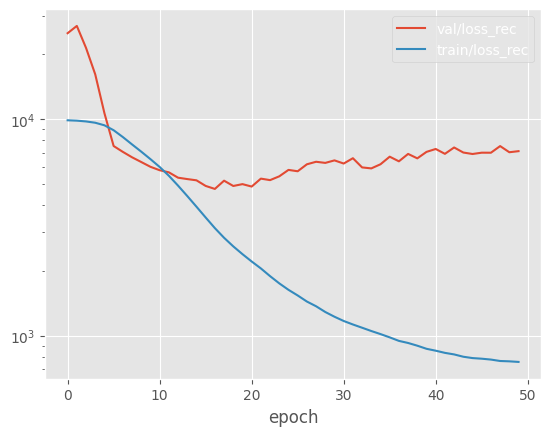

In [31]:
df_hist = read_metrics_csv(trainer1.logger.experiment.metrics_file_path).ffill().bfill()
for key in ['loss_rec']:
    df_hist[[c for c in df_hist.columns if key in c]].plot(logy=True)


<Axes: xlabel='epoch'>

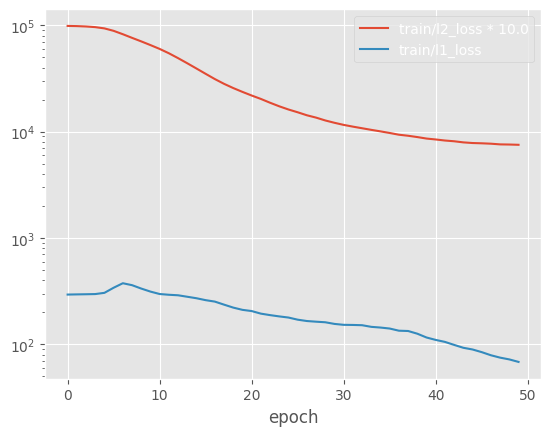

In [32]:
a = df_hist[[c for c in df_hist.columns if 'train/l2' in c]]
a = (a / l1_coeff ).rename(columns=lambda x: f'{x} * {1/l1_coeff}')
b = df_hist[[c for c in df_hist.columns if 'train/l1' in c]]
pd.concat([a, b], axis=1).plot(
    logy=True
    )


In [33]:
l1_coeff


0.1

<Axes: xlabel='epoch'>

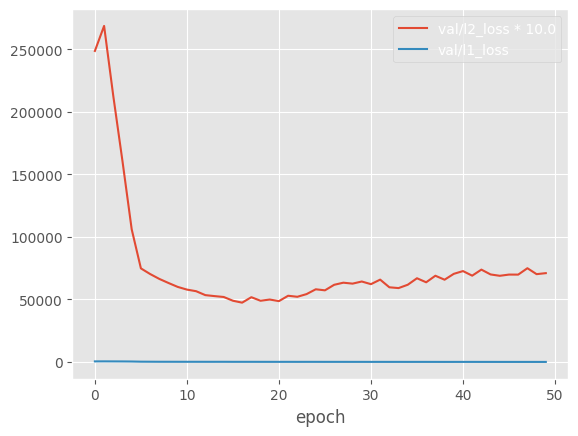

In [34]:
a = df_hist[[c for c in df_hist.columns if 'val/l2' in c]]
a = (a / l1_coeff ).rename(columns=lambda x: f'{x} * {1/l1_coeff}')
b = df_hist[[c for c in df_hist.columns if 'val/l1' in c]]
pd.concat([a, b], axis=1).plot(
    # logy=True
    )


In [35]:
print(c_in)
x = x.to(net.device)
with torch.no_grad():
    y = net(x)

# how is the l1/l2 balance now?
{k: v.abs().mean() for k,v in y.items()}


torch.Size([27, 4096])


{'pred': tensor(0.3610),
 'l1_loss': tensor(46.2532),
 'l2_loss': tensor(499.3340),
 'loss': tensor(503.9594),
 'latent': tensor(0.1428),
 'h_rec': tensor(0.1245)}

In [36]:
y['latent'].shape
x.shape


torch.Size([64, 27, 4096, 1])

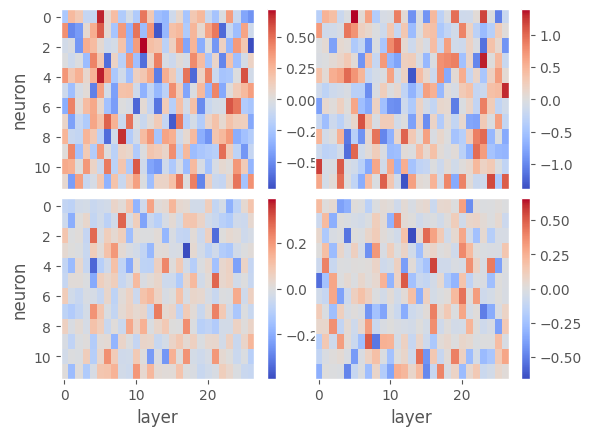

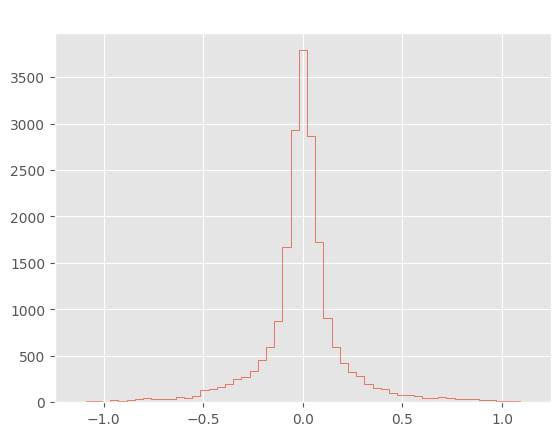

In [37]:
from matplotlib import cm
latent = y['latent'].cpu()#.reshape(64, 24, 12) # [Batch, Latent, Layer]
vmax=latent.abs().max()
for i in range(4):
    plt.subplot(2, 2, i+1)
    vmax = latent[i].abs().max()
    plt.imshow(latent[i], cmap=cm.coolwarm, interpolation='none', aspect='auto'
               , vmin=-vmax, vmax=vmax
               )
    plt.xlabel('layer')
    plt.ylabel('neuron')
    if i<2:
        plt.xlabel('')
        plt.xticks([])
    if i%2==1:
        plt.ylabel('')
        plt.yticks([])
    plt.grid(False)
    plt.colorbar()
# plt.colorbar()
plt.subplots_adjust(wspace=0.05, hspace=0.05)
plt.show()


# plt.imshow(latent[1], cmap=cm.coolwarm, interpolation='none', aspect='auto', vmin=-vmax, vmax=vmax)
# plt.xlabel('layer')
# plt.ylabel('neuron')
# plt.colorbar()
plt.show()

latentf = rearrange(latent, 'b n l -> (b n) l').flatten()
vmax=(latentf.abs().mean() + 5* latentf.abs().std()).item()
plt.hist(latentf, bins=55, range=[-vmax, vmax], histtype='step')
plt.title('latents by layer')
plt.show()


In [38]:
# % reconstruction error
orig = rearrange(x, 'b l h 1 -> b h l') 
diff = (orig- y['h_rec']).abs() / (orig + 1e-5).abs()
diff.abs().mean()


tensor(8.9606)

## Train probe

In [39]:
net.ae_mode(1)
trainer2 = pl.Trainer(precision="16-mixed",
                gradient_clip_val=20,
                max_epochs=max_epochs, log_every_n_steps=3, 
                # enable_progress_bar=False, enable_model_summary=False
                )
trainer2.fit(model=net, train_dataloaders=dl_train, val_dataloaders=dl_val)


Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name | Type        | Params
-------------------------------------
0 | ae   | AutoEncoder | 3.7 M 
1 | head | Sequential  | 28.8 K
-------------------------------------
28.8 K    Trainable params
3.7 M     Non-trainable params
3.7 M     Total params
14.760    Total estimated model params size (MB)


requires_grad: False, AutoEncoder(
  (enc): Encoder(
    (conv): Sequential(
      (0): BatchNorm1d(4096, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (1): InceptionBlock(
        (bottleneck): ConvBlock(
          (0): AddCoords1d()
          (1): ParametrizedConv1d(
            4097, 64, kernel_size=(1,), stride=(1,), padding=same, bias=False
            (parametrizations): ModuleDict(
              (weight): ParametrizationList(
                (0): _WeightNorm()
              )
            )
          )
          (2): ReLU()
          (3): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (convs): ModuleList(
          (0): ConvBlock(
            (0): AddCoords1d()
            (1): ParametrizedConv1d(
              65, 64, kernel_size=(7,), stride=(1,), padding=same, bias=False
              (parametrizations): ModuleDict(
                (weight): ParametrizationList(
                  (0): _WeightNorm()
    

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 38/38 [00:02<00:00, 16.76it/s, v_num=123, val/loss_pred=0.943, val/loss_rec=7.25e+3, train/loss_pred=0.104, train/loss_rec=755.0]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Testing DataLoader 3: 100%|██████████| 18/18 [00:00<00:00, 23.26it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃       DataLoader 1        ┃       DataLoader 2        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test/acc          │    0.1719532608985901     │    0.6460767984390259     │    0.37896493077278137    │
│       test/l1_loss        │    107.15355682373047     │     96.78995513916016     │     97.97341918945312     │
│       test/l2_loss        │      6058.6162109375      │      7239.423828125       │      7134.775390625       │
│      test/loss_pred       │    1.8178952932357788     │    0.9434764385223389     │     1.302729845046997     │
│       test/loss_rec       │       6069.33203125       │      7249.103515625       │     7144.57275390625      │
│          test/n           │          2396.0           │          1198.0           │          1198.0           │
└───────────────────────────┴───────────────────────────┴───────────────────────────┴───────────────────────────┘

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 3        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test/acc          │    0.2511415481567383     │
│       test/l1_loss        │     94.82392883300781     │
│       test/l2_loss        │     6796.65478515625      │
│      test/loss_pred       │    1.0872248411178589     │
│       test/loss_rec       │     6806.13720703125      │
│          test/n           │          1095.0           │
└───────────────────────────┴───────────────────────────┘

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting DataLoader 0: 100%|██████████| 19/19 [00:00<00:00, 30.96it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting DataLoader 0: 100%|██████████| 19/19 [00:00<00:00, 31.89it/s]
probe results on subsets of the data
acc=51.25%,	n=2396,	[] 
acc=60.93%,	n=1016,	[instructed_to_lie==True] 
acc=44.13%,	n=1380,	[instructed_to_lie==False] 
acc=53.86%,	n=2265,	[llm_ans==label_true] 
acc=40.83%,	n=1511,	[llm_ans==label_instructed] 
acc=6.11%,	n=131,	[instructed_to_lie==True & llm_ans==label_instructed] 
acc=69.04%,	n=885,	[instructed_to_lie==True & llm_ans!=label_instructed] 
probe accuracy for quadrants


llm gave,did,didn't
instructed to,,
tell a truth,0.44,NaN
tell a lie,0.06,0.69


⭐PRIMARY METRIC⭐ acc=51.25% from probe
⭐SECONDARY METRIC⭐ acc_lie_lie=6.11% from probe


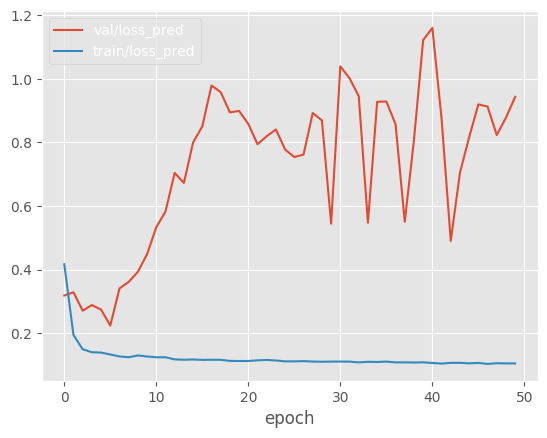

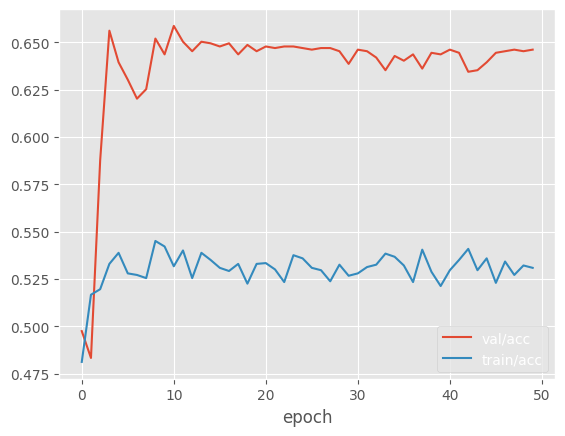

In [40]:

# look at hist
df_hist = read_metrics_csv(trainer2.logger.experiment.metrics_file_path).ffill().bfill()
for key in ['loss_pred']:
    df_hist[[c for c in df_hist.columns if key in c]].plot()
    
for key in ['acc']:
    df_hist[[c for c in df_hist.columns if key in c]].plot()
df_hist

# predict
dl_test = dm.test_dataloader()
# print(f"training with x_feats={x_feats} with c={c}")
rs = trainer2.test(net, dataloaders=[dl_train, dl_val, dl_test, dl_oos])

testval_metrics = calc_metrics(dm, trainer2, net, use_val=True)
rs = rename(rs, ['train', 'val', 'test', 'oos'])
# rs['test'] = {**rs['test'], **test_metrics}
rs['test']['acc_lie_lie'] = testval_metrics['acc_lie_lie']
rs['testval_metrics'] = rs['test']


In [41]:
0.2094*50000


10470.0

# how well does it generalize?

In [42]:
# print(f"training with x_feats={x_feats} with c={c}")
rs2 = trainer1.test(net, dataloaders=[dl_oos])
rs2 = rename(rs2, ks=['oos'])

testval_metrics2 = calc_metrics(dm_oos, trainer1, net, use_val=True)
rs['oos']['acc_lie_lie'] = testval_metrics2['acc_lie_lie']
rs['oos_metrics'] = rs2['oos']
rs


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Testing DataLoader 0: 100%|██████████| 18/18 [00:00<00:00, 25.58it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test/acc          │    0.2511415481567383     │
│       test/l1_loss        │     94.82392883300781     │
│       test/l2_loss        │     6796.65478515625      │
│      test/loss_pred       │    1.0872248411178589     │
│       test/loss_rec       │     6806.13720703125      │
│          test/n           │          1095.0           │
└───────────────────────────┴───────────────────────────┘

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting DataLoader 0: 100%|██████████| 5/5 [00:00<00:00, 29.22it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting DataLoader 0: 100%|██████████| 5/5 [00:00<00:00, 34.40it/s]
probe results on subsets of the data
acc=22.99%,	n=548,	[] 
acc=26.34%,	n=205,	[instructed_to_lie==True] 
acc=20.99%,	n=343,	[instructed_to_lie==False] 
acc=25.05%,	n=503,	[llm_ans==label_true] 
acc=18.56%,	n=388,	[llm_ans==label_instructed] 
acc=0.00%,	n=45,	[instructed_to_lie==True & llm_ans==label_instructed] 
acc=33.75%,	n=160,	[instructed_to_lie==True & llm_ans!=label_instructed] 
probe accuracy for quadrants


llm gave,did,didn't
instructed to,,
tell a truth,0.21,NaN
tell a lie,0.00,0.34


⭐PRIMARY METRIC⭐ acc=22.99% from probe
⭐SECONDARY METRIC⭐ acc_lie_lie=0.00% from probe


{'train': {'acc': 0.1719532608985901,
  'loss_pred': 1.8178952932357788,
  'loss_rec': 6069.33203125,
  'l1_loss': 107.15355682373047,
  'l2_loss': 6058.6162109375,
  'n': 2396.0},
 'val': {'acc': 0.6460767984390259,
  'loss_pred': 0.9434764385223389,
  'loss_rec': 7249.103515625,
  'l1_loss': 96.78995513916016,
  'l2_loss': 7239.423828125,
  'n': 1198.0},
 'test': {'acc': 0.37896493077278137,
  'loss_pred': 1.302729845046997,
  'loss_rec': 7144.57275390625,
  'l1_loss': 97.97341918945312,
  'l2_loss': 7134.775390625,
  'n': 1198.0,
  'acc_lie_lie': 0.061068702290076333},
 'oos': {'acc': 0.2511415481567383,
  'loss_pred': 1.0872248411178589,
  'loss_rec': 6806.13720703125,
  'l1_loss': 94.82392883300781,
  'l2_loss': 6796.65478515625,
  'n': 1095.0,
  'acc_lie_lie': 0.0},
 'testval_metrics': {'acc': 0.37896493077278137,
  'loss_pred': 1.302729845046997,
  'loss_rec': 7144.57275390625,
  'l1_loss': 97.97341918945312,
  'l2_loss': 7134.775390625,
  'n': 1198.0,
  'acc_lie_lie': 0.0610687

# End to end?


In [43]:
net.ae_mode(2)
trainer2 = pl.Trainer(precision="16-mixed",
                gradient_clip_val=20,
                max_epochs=max_epochs, log_every_n_steps=3, 
                # enable_progress_bar=False, enable_model_summary=False
                )
trainer2.fit(model=net, train_dataloaders=dl_train, val_dataloaders=dl_val)


Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name | Type        | Params
-------------------------------------
0 | ae   | AutoEncoder | 3.7 M 
1 | head | Sequential  | 28.8 K
-------------------------------------
3.7 M     Trainable params
0         Non-trainable params
3.7 M     Total params
14.760    Total estimated model params size (MB)


requires_grad: True, AutoEncoder(
  (enc): Encoder(
    (conv): Sequential(
      (0): BatchNorm1d(4096, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (1): InceptionBlock(
        (bottleneck): ConvBlock(
          (0): AddCoords1d()
          (1): ParametrizedConv1d(
            4097, 64, kernel_size=(1,), stride=(1,), padding=same, bias=False
            (parametrizations): ModuleDict(
              (weight): ParametrizationList(
                (0): _WeightNorm()
              )
            )
          )
          (2): ReLU()
          (3): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (convs): ModuleList(
          (0): ConvBlock(
            (0): AddCoords1d()
            (1): ParametrizedConv1d(
              65, 64, kernel_size=(7,), stride=(1,), padding=same, bias=False
              (parametrizations): ModuleDict(
                (weight): ParametrizationList(
                  (0): _WeightNorm()
     

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 38/38 [00:05<00:00,  7.27it/s, v_num=124, val/loss_pred=0.109, val/loss_rec=4.21e+3, train/loss_pred=0.0837, train/loss_rec=530.0]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Testing DataLoader 3: 100%|██████████| 18/18 [00:00<00:00, 29.62it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃       DataLoader 1        ┃       DataLoader 2        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test/acc          │    0.2996661067008972     │    0.6719532608985901     │    0.5893155336380005     │
│       test/l1_loss        │    204.13099670410156     │     168.3704376220703     │     173.6667022705078     │
│       test/l2_loss        │     3314.19677734375      │     4195.55810546875      │         5150.125          │
│      test/loss_pred       │    0.24005833268165588    │    0.10902327299118042    │    0.2060735672712326     │
│       test/loss_rec       │      3334.6103515625      │      4212.3955078125      │     5167.49072265625      │
│          test/n           │          2396.0           │          1198.0           │          1198.0           │
└───────────────────────────┴───────────────────────────┴───────────────────────────┴───────────────────────────┘

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 3        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test/acc          │    0.43926939368247986    │
│       test/l1_loss        │     168.7139129638672     │
│       test/l2_loss        │       4968.8515625        │
│      test/loss_pred       │    0.18025663495063782    │
│       test/loss_rec       │       4985.72265625       │
│          test/n           │          1095.0           │
└───────────────────────────┴───────────────────────────┘

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting DataLoader 0: 100%|██████████| 19/19 [00:00<00:00, 31.54it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting DataLoader 0: 100%|██████████| 19/19 [00:00<00:00, 31.27it/s]
probe results on subsets of the data
acc=63.06%,	n=2396,	[] 
acc=68.01%,	n=1016,	[instructed_to_lie==True] 
acc=59.42%,	n=1380,	[instructed_to_lie==False] 
acc=65.61%,	n=2265,	[llm_ans==label_true] 
acc=55.92%,	n=1511,	[llm_ans==label_instructed] 
acc=19.08%,	n=131,	[instructed_to_lie==True & llm_ans==label_instructed] 
acc=75.25%,	n=885,	[instructed_to_lie==True & llm_ans!=label_instructed] 
probe accuracy for quadrants


llm gave,did,didn't
instructed to,,
tell a truth,0.59,NaN
tell a lie,0.19,0.75


⭐PRIMARY METRIC⭐ acc=63.06% from probe
⭐SECONDARY METRIC⭐ acc_lie_lie=19.08% from probe


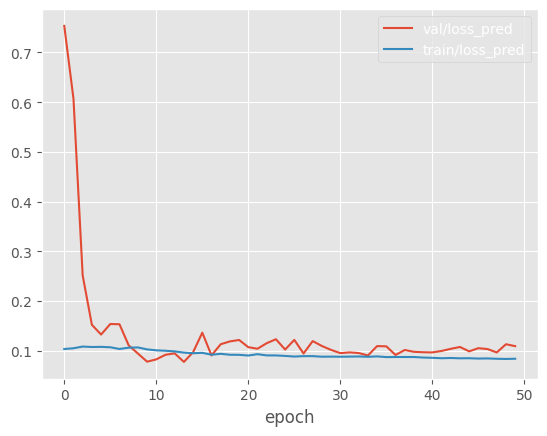

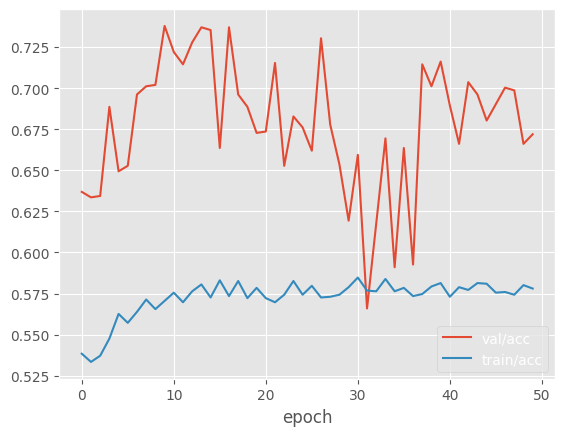

In [44]:

# look at hist
df_hist = read_metrics_csv(trainer2.logger.experiment.metrics_file_path).ffill().bfill()
for key in ['loss_pred']:
    df_hist[[c for c in df_hist.columns if key in c]].plot()
    
for key in ['acc']:
    df_hist[[c for c in df_hist.columns if key in c]].plot()
df_hist

# predict
dl_test = dm.test_dataloader()
# print(f"training with x_feats={x_feats} with c={c}")
rs = trainer2.test(net, dataloaders=[dl_train, dl_val, dl_test, dl_oos])

testval_metrics = calc_metrics(dm, trainer2, net, use_val=True)
rs = rename(rs, ['train', 'val', 'test', 'oos'])
# rs['test'] = {**rs['test'], **test_metrics}
rs['test']['acc_lie_lie'] = testval_metrics['acc_lie_lie']
rs['testval_metrics'] = rs['test']


In [45]:
# print(f"training with x_feats={x_feats} with c={c}")
rs2 = trainer1.test(net, dataloaders=[dl_oos])
rs2 = rename(rs2, ks=['oos'])

testval_metrics2 = calc_metrics(dm_oos, trainer1, net, use_val=True)
rs['oos']['acc_lie_lie'] = testval_metrics2['acc_lie_lie']
rs['oos_metrics'] = rs2['oos']
rs


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Testing DataLoader 0: 100%|██████████| 18/18 [00:00<00:00, 27.25it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test/acc          │    0.43926939368247986    │
│       test/l1_loss        │     168.7139129638672     │
│       test/l2_loss        │       4968.8515625        │
│      test/loss_pred       │    0.18025663495063782    │
│       test/loss_rec       │       4985.72265625       │
│          test/n           │          1095.0           │
└───────────────────────────┴───────────────────────────┘

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting DataLoader 0: 100%|██████████| 5/5 [00:00<00:00, 34.54it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting DataLoader 0: 100%|██████████| 5/5 [00:00<00:00, 35.48it/s]
probe results on subsets of the data
acc=42.70%,	n=548,	[] 
acc=41.46%,	n=205,	[instructed_to_lie==True] 
acc=43.44%,	n=343,	[instructed_to_lie==False] 
acc=45.53%,	n=503,	[llm_ans==label_true] 
acc=39.69%,	n=388,	[llm_ans==label_instructed] 
acc=11.11%,	n=45,	[instructed_to_lie==True & llm_ans==label_instructed] 
acc=50.00%,	n=160,	[instructed_to_lie==True & llm_ans!=label_instructed] 
probe accuracy for quadrants


llm gave,did,didn't
instructed to,,
tell a truth,0.43,NaN
tell a lie,0.11,0.5


⭐PRIMARY METRIC⭐ acc=42.70% from probe
⭐SECONDARY METRIC⭐ acc_lie_lie=11.11% from probe


{'train': {'acc': 0.2996661067008972,
  'loss_pred': 0.24005833268165588,
  'loss_rec': 3334.6103515625,
  'l1_loss': 204.13099670410156,
  'l2_loss': 3314.19677734375,
  'n': 2396.0},
 'val': {'acc': 0.6719532608985901,
  'loss_pred': 0.10902327299118042,
  'loss_rec': 4212.3955078125,
  'l1_loss': 168.3704376220703,
  'l2_loss': 4195.55810546875,
  'n': 1198.0},
 'test': {'acc': 0.5893155336380005,
  'loss_pred': 0.2060735672712326,
  'loss_rec': 5167.49072265625,
  'l1_loss': 173.6667022705078,
  'l2_loss': 5150.125,
  'n': 1198.0,
  'acc_lie_lie': 0.19083969465648856},
 'oos': {'acc': 0.43926939368247986,
  'loss_pred': 0.18025663495063782,
  'loss_rec': 4985.72265625,
  'l1_loss': 168.7139129638672,
  'l2_loss': 4968.8515625,
  'n': 1095.0,
  'acc_lie_lie': 0.1111111111111111},
 'testval_metrics': {'acc': 0.5893155336380005,
  'loss_pred': 0.2060735672712326,
  'loss_rec': 5167.49072265625,
  'l1_loss': 173.6667022705078,
  'l2_loss': 5150.125,
  'n': 1198.0,
  'acc_lie_lie': 0.19